# Timing Core Equity Factors

M2 203 Econometrics Project, Faune Blanchard

--- 

## Preliminary preparations

First and foremost, we start by importing the packages that we will need to conduct this work.

Then, we import the data file, and do some quick preprocessing: we differentiate the first column which corresponds to the index, from the other columns which correspond to the components.

We use Polars instead of Pandas because of the added speed and flexibility.

We also import locally from our pre-coded functions in models.py

In [467]:
from typing import Callable
import math
import random
import polars as pl 
import polars.selectors as cs
import numpy as np

from scipy.optimize import minimize, fmin_bfgs
from scipy.stats import t
from sklearn.utils import resample

from concurrent.futures import ThreadPoolExecutor, as_completed, ProcessPoolExecutor

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.multivariate.pca import PCA as PCA
from statsmodels.tsa.statespace.structural import UnobservedComponents
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

In [118]:
raw_data = pl.read_excel(source=r".\DATA.xlsx").rename({'__UNNAMED__0' : 'date'})
index = raw_data.select('date', pl.col("^.*ESTX 50.*$").alias("index"))
stocks = raw_data.drop("^.*ESTX 50.*$")
del raw_data # we won't need this variable anymore

## **Part 1**  

We want to extract the first latent factor of the index,  by using principal component analysis. 

The goal is to find the most important unobservable random variable that could explain the index's returns.

We normalize the returns so that they are all on the same scale.

In [309]:
stocks.drop('date').to_numpy()

array([[ 0.08218657,  0.03150226,  0.0329816 , ...,  0.05563982,
        -0.08565676,  0.01908367],
       [-0.05066345, -0.07189154,  0.06690555, ..., -0.04700913,
        -0.02687307, -0.02474097],
       [-0.08799238, -0.04309925, -0.03418718, ..., -0.02765142,
        -0.10149158, -0.10538727],
       ...,
       [ 0.07377723, -0.00096577,  0.02543308, ...,  0.        ,
         0.02316201, -0.01060552],
       [-0.07409659, -0.02320251, -0.07776277, ...,  0.        ,
        -0.05645199, -0.06536373],
       [-0.07348196,  0.0772021 ,  0.01686327, ...,  0.        ,
        -0.11272281, -0.09242223]], shape=(282, 47))

In [310]:
# stocks_list = stocks.drop('date').select(pl.concat_list(pl.all()).alias('stocks')).to_series().to_list()
stocks_list = scale(stocks.drop('date').to_numpy())
pca = PCA((stocks_list))

pc1 = pl.Series(name = "PC1", values=scale(pca.factors[:,0])).explode()

print(f"The percentage of explained var is {(pca.eigenvals/np.sum(pca.eigenvals))[0]*100} %")


The percentage of explained var is 42.500273883008816 %


We count the percentage of negative values (if it's lower than 50% then we don't need to adjust)

In [311]:
pl.DataFrame(pc1).filter(pl.col('PC1').le(0)).shape[0]/pl.DataFrame(pc1).shape[0]

0.5460992907801419

We adjust the results:

In [312]:
pc1 = -1*pc1

We plot the first results

<Axes: xlabel='date'>

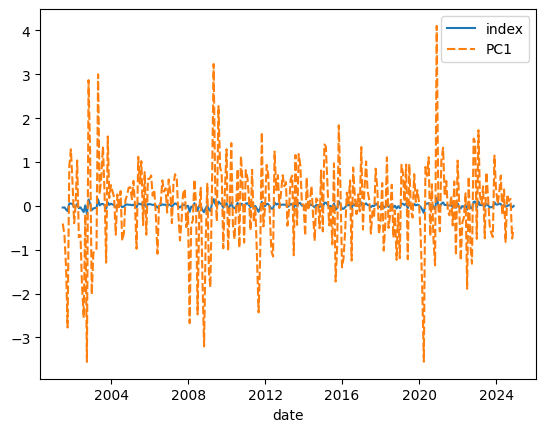

In [313]:
sns.lineplot(index.with_columns(pc1).to_pandas().set_index('date'))

We can clearly see that the volatilities don't match, therefore we can then rescale the principal component to the same volatility as that of the benchmark.

We have

In [314]:
print(f"Principal component std : {pc1.std()} \nIndex std : {index.select('index').std().to_series().to_list()[0]}")

Principal component std : 1.0017777791811964 
Index std : 0.05220421089896673


In [315]:
pc1 = pl.DataFrame(pc1).select(pl.col('PC1').mul(index.select('index').std().to_series().to_list()[0]/pc1.std()))

Text(0.5, 1.0, 'Principal component and Index')

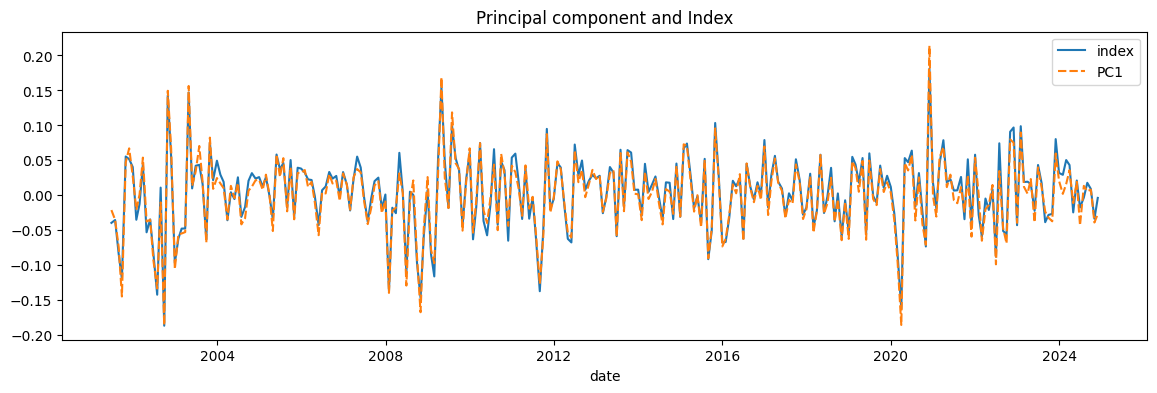

In [316]:
plt.figure(figsize=(14,4))
sns.lineplot(index.with_columns(pc1).to_pandas().set_index('date'))
plt.title('Principal component and Index')

We then regress each stock returns on this principal component, using multiple linear regressions
For this we define a function that applied a linear regression and returns the beta, and we apply it to each column of the stocks dataframe

In [317]:
def get_beta(col_name: str) -> float:
    model = LinearRegression()
    model.fit(X=np.array(pc1.to_series().to_list()).reshape(-1,1), y=stocks.select(col_name).to_series().to_list())
    return float(model.coef_[0])

We start by testing with the first stock:

In [318]:
print("The first stock is", stocks.drop('date').columns[0], f"\nIts beta is {get_beta(stocks.drop('date').columns[0])}")

The first stock is ANHEUSER-BUSCH INBEV SA/NV 
Its beta is 0.7007734180252089


We then define a function to parralelize the calls so that the code is more efficient (not necessary but better practice)

In [319]:
def parralelize_calls(data: pl.DataFrame, func: Callable = get_beta) -> dict:
    results = {}
    with ThreadPoolExecutor() as executor:
        future_to_col = {executor.submit(func, col_name): col_name for col_name in set(data.columns)}
        for future in as_completed(future_to_col):
            col_name = future_to_col[future]
            try:
                results[col_name] = future.result()
                # print(f"stock {col_name} succesful")
            except Exception as exc:
                print(f'{col_name} generated an exception: {exc}')
    return results

In [320]:
betas = parralelize_calls(stocks.drop('date'))

We then sort the betas by the original order (which is changed by the parralelization)

In [321]:
betas_list = (
    pl.DataFrame(
        {
            'names': [k for k,v in betas.items()], 
            'betas' : [v for k,v in betas.items()]
        }
    )
    .join(
        stocks
        .unpivot(
            cs.numeric(), 
            index="date", 
            variable_name=('names')
        )
        .group_by(
            'names', 
            maintain_order=True
        )
        .mean()
        .drop('date'), 
        on='names'
    )
    .select('betas')
    .to_series()
    .to_list()
)

In [322]:
np.array(betas_list)

array([0.70077342, 0.660752  , 0.81397091, 0.6083318 , 1.31545079,
       1.44314291, 1.40610805, 1.12980495, 1.12325283, 1.47626218,
       1.15155146, 0.51648655, 1.33626181, 0.86139114, 1.62011068,
       0.78435726, 0.81813463, 1.0814864 , 0.69423242, 0.52319791,
       0.73250185, 0.76143405, 0.935958  , 1.62613413, 0.59038639,
       1.86275902, 1.41996191, 0.75202716, 1.19189779, 1.42270092,
       1.0593961 , 1.0968322 , 0.91757863, 0.61166327, 0.71917182,
       1.14020299, 1.13030854, 0.5253187 , 1.3791295 , 1.1157291 ,
       1.25604778, 0.96231036, 0.85895881, 0.68755252, 0.408021  ,
       0.83713598, 1.26812272])

We can then plot the rough results to see where the values are

Text(0.5, 1.0, 'Beta of each stock to the PC1')

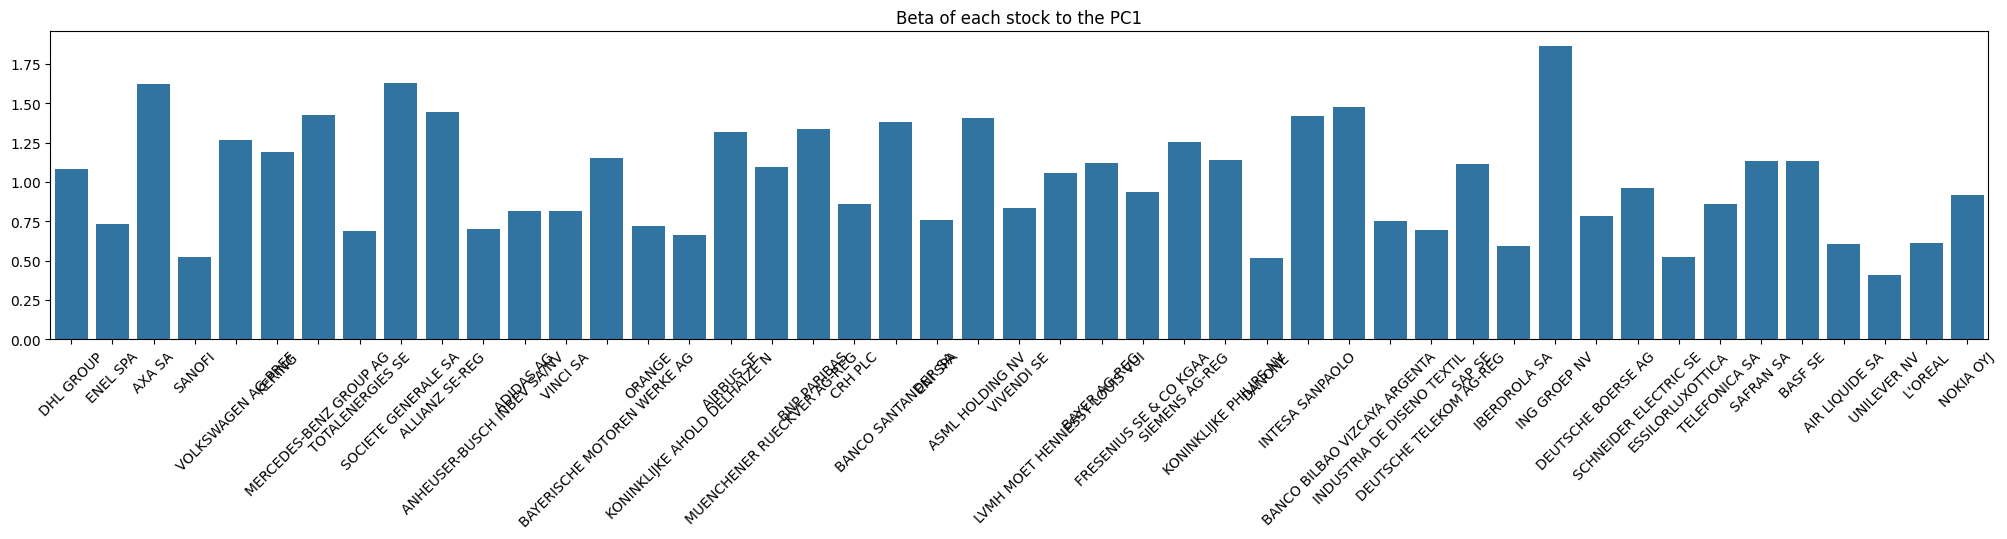

In [323]:
plt.figure(figsize=(25,4))
sns.barplot(betas)
ticks = plt.xticks(rotation=45) 
del ticks
plt.title('Beta of each stock to the PC1')

We will then try to compute the weights of the portfolio that replicates the the core equity factor

For this we will use the following optimization problem:

$$
Argmin_{w_k} (w_1'\hat\Omega w_1)
\newline
s.t. 
\newline
\sum w_{1,i} = 1
\newline
w_{1,i} \ge 0
\newline
\sum w_{1,i} \hat \beta_{1,i} = 1

$$

We therefore need to define the covariance matrix, the functoin to minimize, the constraints and the bounds.

Then, we can solve the optimization problem

In [324]:
cov_matrix = stocks.drop('date').to_pandas().cov()
n = len(stocks.drop('date').columns)
# transofmr betas into list so that its compatible with the scipy function 
betas_list = np.array(betas_list)
# define objective function:
def get_portfolio_variance(weights: np.array) -> float: 
    return np.dot(weights.T, np.dot(cov_matrix, weights))

#define constraints
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}, 
               {'type': 'eq', 'fun': lambda weights: np.dot(weights, betas_list) - 1}
            #    {'type': 'ineq', 'fun': lambda weights: weights}) 
)
# define bounds (each weight is between 0 and 1) (can't be negative)
bounds = [(0, 1) for _ in range(n)]
# initial guess for weights (equi weighted)
init_weights = np.ones(n) / n

We then solve the optimization problem using scipy.minimize

In [325]:
result = minimize(get_portfolio_variance, init_weights, method='SLSQP', bounds=bounds, constraints=constraints)
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0027338623333963284
       x: [ 2.167e-02  2.156e-02 ...  2.142e-02  2.089e-02]
     nit: 2
     jac: [ 3.844e-03  3.784e-03 ...  4.648e-03  6.972e-03]
    nfev: 96
    njev: 2

In [326]:
ptf = (
    pl.DataFrame(
        {
            'names': [k for k,v in betas.items()], 
            'betas' : betas_list
        }
    )
    .with_columns(
        pl.Series(
            name = 'weights', 
            values = result.x
        )
    )
)

To compute the portfolio's value through time, we need to compute the weights * returns

In [327]:
replicating_ptf = pl.Series(name = 'replicating_ptf', values=np.dot(a=result.x, b=np.transpose(stocks_list)))

We can plot the first results

<Axes: xlabel='date'>

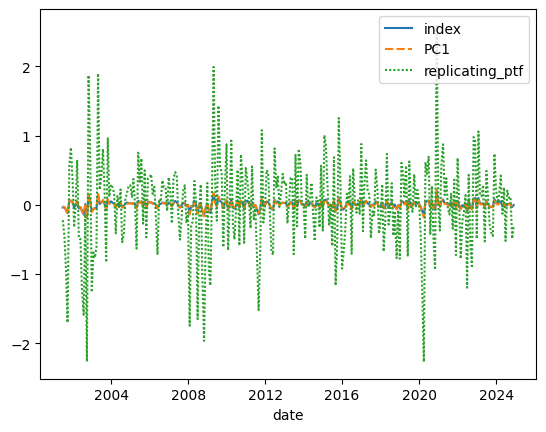

In [328]:
sns.lineplot(index.with_columns(
    pc1.select('PC1').to_series(), 
    replicating_ptf
    ).to_pandas().set_index('date'))

We can see that we need to scale the weights so that we get a similar volatility

In [329]:
print(f"Replicating Portfolio std : {replicating_ptf.std()} \nIndex std : {index.select('index').std().to_series().to_list()[0]}")

Replicating Portfolio std : 0.6415741060885659 
Index std : 0.05220421089896673


In [330]:
coef = index.select('index').std().to_series().to_list()[0]/replicating_ptf.std()
weights_adjusted = result.x * coef

In [245]:
# weights_adjusted = (
#     pl.DataFrame(ptf)
#     .select(
#         pl.col('weights')
#         .mul(
#             index.select('index').std().to_series().to_list()[0]/replicating_ptf.std()
#         )
#     )
# )

In [331]:
replicating_ptf = (
    pl.Series(
        name = 'replicating_ptf', 
        values=np.dot(a=weights_adjusted, b=np.transpose(stocks_list))
    )
)

Text(0.5, 1.0, 'Index, First Component, and Replicating Portfolio')

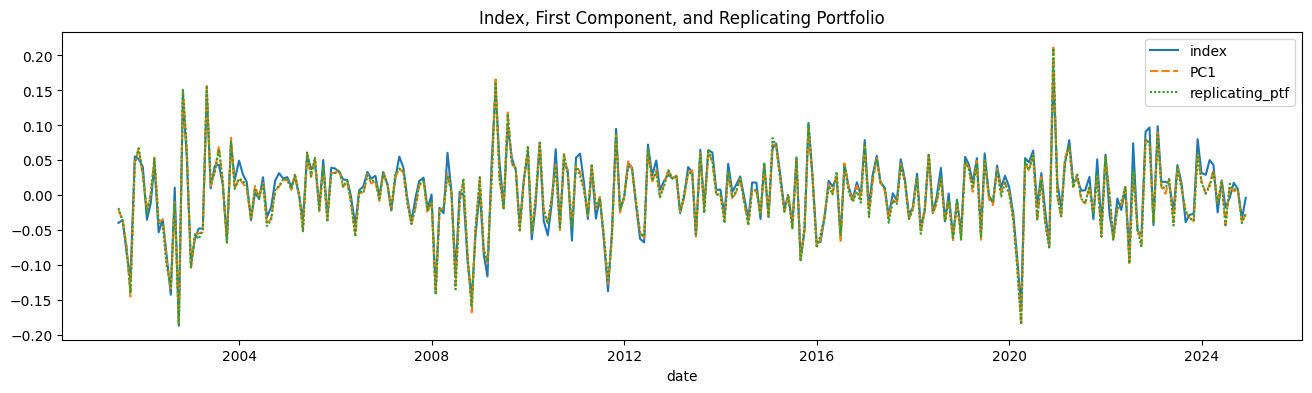

In [332]:
plt.figure(figsize=(16,4))
sns.lineplot(index.with_columns(
    pc1.select('PC1').to_series(), 
    replicating_ptf
    ).to_pandas().set_index('date'))
plt.title('Index, First Component, and Replicating Portfolio')

Lets plot the weights

Text(0.5, 1.0, 'Weights of each stock')

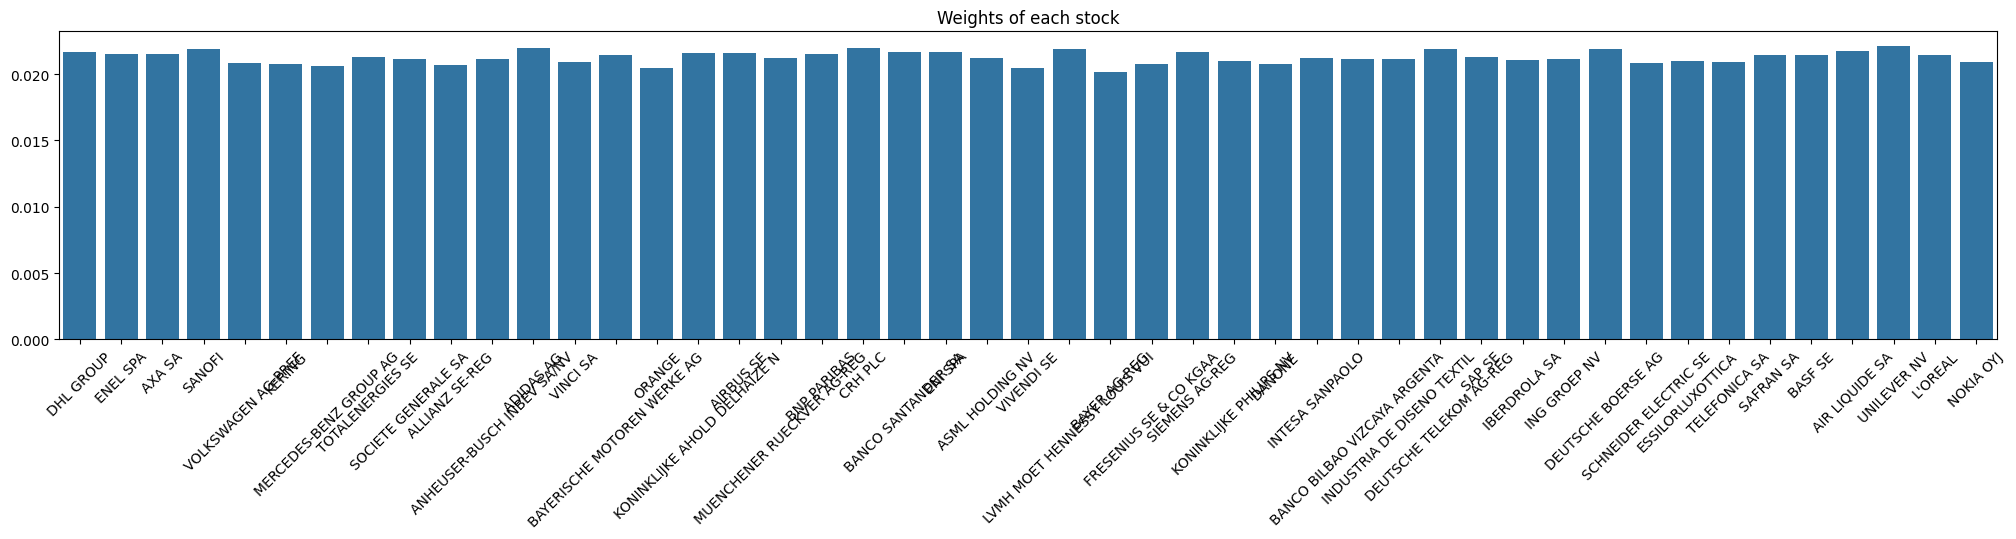

In [333]:
plt.figure(figsize=(25,4))
sns.barplot(ptf.select('names', 'weights').to_pandas().set_index('names').to_dict()['weights'])
ticks = plt.xticks(rotation=45) 
del ticks
plt.title('Weights of each stock')

## **Part 2**

We then want to estimate the alpha of this portfolio against the benchmark, and then compute the confidence interval from the covariance matrix and how that impacts the weights in the replicating portfolio

To estimate the alpha we simply run a linear regression against the market.

Then, we will use bootstrap estimation to find the confidence interval

In [249]:
model = LinearRegression()
model.fit(X=np.array(index.select('index').to_series().to_list()).reshape(-1,1), y=replicating_ptf.to_list())
print(f"The Alpha is {model.intercept_}")

The Alpha is -0.003798599140897537


We can then visualize it :

R^2: 0.96


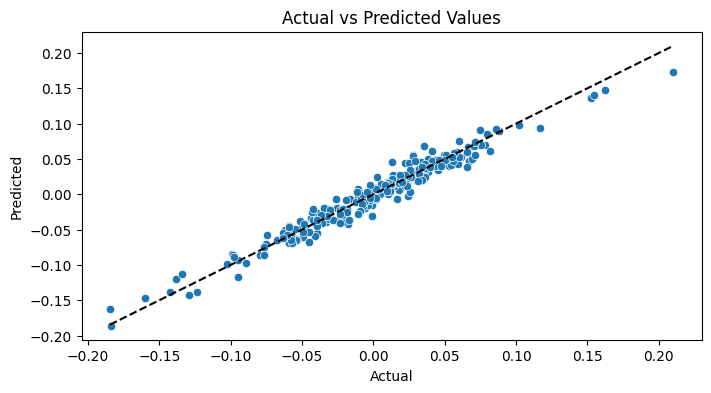

In [250]:
predictions = model.predict(np.array(index.select('index').to_series().to_list()).reshape(-1,1))
predictions_df = pl.DataFrame({
    'Actual': replicating_ptf.to_list(),
    'Predicted': predictions.flatten()
})
plt.figure(figsize=(8,4))
sns.scatterplot(data=predictions_df.to_pandas(), x='Actual', y='Predicted')
plt.plot([predictions_df['Actual'].min(), predictions_df['Actual'].max()],
         [predictions_df['Actual'].min(), predictions_df['Actual'].max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
print(f'R^2: {r2_score(replicating_ptf.to_list(), predictions):.2f}')
del predictions_df

We can now use bootstrapping to estimate the confidence interval

We resample the returns, and then for each bootstrap sample we want to reestimate:
- the optimized portfolio weights 
- the alpha of that portfolio to the market

We start by setting the constants (nb of simulations, etc), we then re-write what we have done as functions

Then we parralelize again so that we are more efficient (especially for a large number of simulations)

In order to parallelize we have to define a function that computes a single bootstrap and then apply it to a pool executor.

We finish by visualizing the results

In [251]:
N_SIMUL = 100

def optimize_ptf(samples: pl.DataFrame) -> pl.Series:

    cov_matrix = samples.drop('date').to_pandas().cov()
    n = len(samples.drop('date').columns)

    # compute betas using previously defined function
    betas = parralelize_calls(samples.drop('date'))

    # transofmr betas into list so that its compatible with the scipy function 
    betas_list = [v for k,v in betas.items()]

    # the objective function has already been defined but wz need to change the covariance matrix it used
    def get_portfolio_variance(weights: np.array) -> float: 
        return np.dot(weights.T, np.dot(cov_matrix, weights))
    
    #define constraints
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}, 
                {'type': 'eq', 'fun': lambda weights: np.dot(weights, betas_list) - 1},  
                {'type': 'ineq', 'fun': lambda weights: weights}) 
    
    # define bounds (each weight is between 0 and 1) (can't be negative)
    bounds = [(0, 1) for _ in range(n)]

    # initial guess for weights (equi weighted)
    init_weights = np.ones(n) / n

    # transform the sample into the right format
    samples_list = scale(np.array(samples.drop('date').select(pl.concat_list(pl.all()).alias('stocks')).to_series().to_list()))
    
    # perform the optimization
    result = minimize(get_portfolio_variance, init_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    replicating_ptf = pl.Series(name = 'replicating_ptf', values=np.dot(a=result.x, b=np.transpose(samples_list)))

    # adjust the weights
    weights_adjusted = pl.DataFrame(ptf).select(pl.col('weights').mul(index.select('index').std().to_series().to_list()[0]/replicating_ptf.std()))

    # returns the replicated portfolio
    return pl.Series(name = 'replicating_ptf', values=np.dot(a=weights_adjusted.to_series().to_list(), b=np.transpose(samples_list)))

def get_alpha(replicating_ptf: pl.Series) -> float:
    model = LinearRegression()
    model.fit(X=np.array(index.select('index').to_series().to_list()).reshape(-1,1), y=replicating_ptf.to_list())
    return float(model.intercept_)
    

In [252]:
def get_bootstrap(seed : float) -> float:
    np.random.seed(seed)
    bootstrap_samples = resample(stocks, replace=True)
    replicating_ptf = optimize_ptf(bootstrap_samples)
    return get_alpha(replicating_ptf=replicating_ptf)

We then estimate the alphas

In [253]:
seeds = np.random.randint(0, np.iinfo(np.int32).max, size=N_SIMUL)
alpha_estimates = []

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(get_bootstrap, seed) for seed in seeds]
    for future in as_completed(futures):
        alpha_estimates.append(future.result())

We get our first results

<Axes: ylabel='Count'>

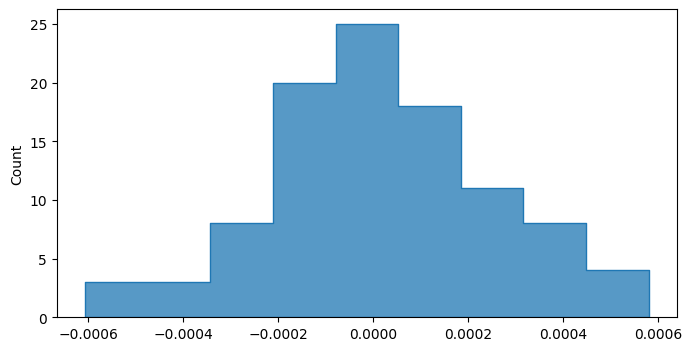

In [254]:
plt.figure(figsize=(8,4))
sns.histplot(alpha_estimates, element='step')

We can then run a larger simulation and write the confidence interval

In [255]:
N_SIMUL = 1000
seeds = np.random.randint(0, np.iinfo(np.int32).max, size=N_SIMUL)
alpha_estimates = []

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(get_bootstrap, seed) for seed in seeds]
    for future in as_completed(futures):
        alpha_estimates.append(future.result())

In [256]:
lower = np.percentile(alpha_estimates, (1 - 0.95) / 2 * 100)
upper = np.percentile(alpha_estimates, (1 + 0.95) / 2 * 100)

Text(0.5, 1.0, 'Confidence interval for the alpha to the market')

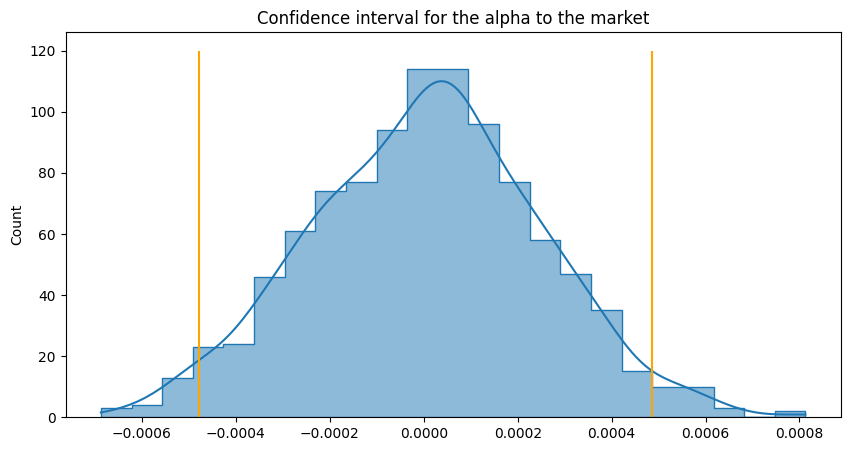

In [257]:
plt.figure(figsize=(10,5))
sns.histplot(alpha_estimates, element='step', kde=True)
plt.vlines(x=lower, ymin=0, ymax=120, colors='orange')
plt.vlines(x=upper, ymin=0, ymax=120, colors='orange')
plt.title('Confidence interval for the alpha to the market')

We notice that this is rougly centered around 0 (even slightly above)

## **Part 3**

We want to estimate the global trend and its slope of the price index which is derived from the resulting portfolio. 

For this, we will use a local linear trend model of the form :
$$
    I_{1, t} = T_{1, t} + \varepsilon_t \\
    T_{1, t}=T_{1, t-1} + S_{1, t-1} + u_t \\
    S_{1, t}=S_{1, t-1}+v_t
$$

With a specific relationship for the variance terms which we will specify later.

We start by calculating the index price from the portfolio returns (we choose a base of 1000 to match the original base of the EURO STOXX50 index). 

We will then estimate the model using statsmodels, with a constrained fit for the variance relationship.

In [421]:
# calculating an d visualizing the index price of the ptf vs the index
data = (
    index
    .with_columns(pl.Series(
        name='replicating_ptf',
        values= np.dot(stocks.to_pandas().iloc[:,1:], result.x)
    ))
    .with_columns(
        price_ptf = (pl.col('replicating_ptf').add(1)).cum_prod()*1000,
        price_index = (pl.col('index').add(1)).cum_prod()*1000
    )
)

<Axes: xlabel='date'>

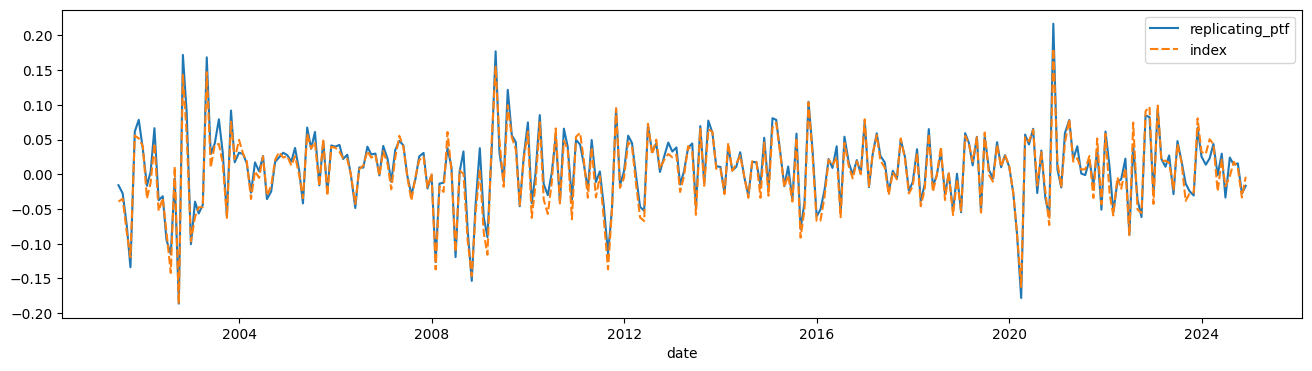

In [422]:
plt.figure(figsize=(16,4))
sns.lineplot(data.select('date', 'replicating_ptf', 'index').to_pandas().set_index('date'))

<Axes: xlabel='date'>

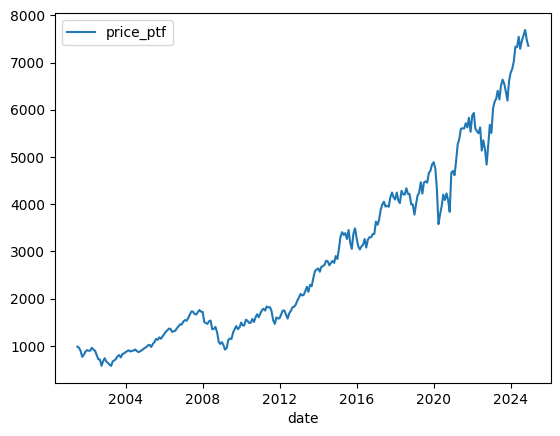

In [423]:
sns.lineplot(data.select('date', 'price_ptf').to_pandas().set_index('date'))

We see that there is quite a difference between the two. 

We then compute the portfolio variance so that we can use it when forcing the variance terms.

In [424]:
ptf_std = data.select('replicating_ptf').std().to_series().to_list()[0]

We can write the function to apply the kalman filter

In [425]:
import math

def Kalman(y,z,u):
    global _Q, _H, _Y, _Z, _X0, _P0, _A, _C, _U, _nZ, _nU, out_opt
    Y=y
    Z=z
    nZ=len(Z.T)
    param=np.zeros((5))
    #INITIAL STATES
    X0=np.zeros((nZ,1))
    #INITIAL STATE COVARIANCE
    P0=np.zeros((nZ,nZ))  
    #TRANSITION MATRIX
    A=np.eye(nZ)
    A[0,1]=1    
    #STATE INNOVATION COVARIANCE MATRIX
    Q=np.zeros((nZ,nZ))    
    #SIGNAL COVARIANCE MATRIX
    H=np.zeros((1,1))
    #CONTROL COEFFS  
    if np.isscalar(u)==1:
        U=0
        C=0
        nU=0
    else:
        U=u
        nU=len(U.T)
        C=np.zeros((nZ,nU))           
    #GLOBAL PARAMETERS
    _Q=Q ; _H=H ; _Y=Y ; _Z=Z ; _X0=X0 ; _P0=P0 ; _A=A ; _nZ=nZ ; _U=U ; _C=C ; _nU=nU     
    #OPTIMIZATION
    param=fmin_bfgs(ml_Multi,param,gtol=0.001)   
    #ESTIMATION WITH OPTIMIZED PARAMETERS
    H=np.exp(param[0])
    Q[0,0]=0.5*H
    Q[1,1]=0.5*Q[0,0]
    X0[0,0]=param[1]
    X0[1,0]=param[2]
    P0[0,0]=np.exp(param[3])
    P0[1,1]=np.exp(param[4])
    (likely,XOUT,POUT)=kalman_filter(Y,Z,X0,P0,A,Q,H,U,C)
    return XOUT,POUT,param
def ml_Multi(param):    
    global _Q, _H, _Y, _Z, _X0, _P0, _A, _nZ, _C, out_opt
    param=param.reshape(max(param.shape))
    _H=np.exp(param[0])
    _Q[0,0]=0.5*_H
    _Q[1,1]=0.5*_Q[0,0]
    _X0[0,0]=param[1]
    _X0[1,0]=param[2]
    _P0[0,0]=np.exp(param[3])
    _P0[1,1]=np.exp(param[4])
    (likely,XOUT,POUT)=kalman_filter(_Y,_Z,_X0,_P0,_A,_Q,_H,_U,_C)
    likely=np.reshape(likely,((1)))
    return -likely
#
#
#
def kalman_filter(Y,Z,X0,P0,A,Q,H,U,C):
    #Y(T,1) Z(T,nZ) X0(nZ) P0(nZ,nZ) A(nZ,nZ) Q(nZ,nZ) H(1) U(T,nU) C(nZ,nU)
    nZ=len(Z.T)
    nT=len(Y)
    Xt=X0
    Pt=P0
    Zt=np.zeros((1,nZ))
    Xout=np.zeros((nT,nZ))
    Pout=np.zeros((nT,nZ,nZ))
    l1=0.0
    l2=0.0
    likely=0.0
    #LOOP
    t=0
    while t<nT:
        #estimation step
        if np.isscalar(U)==1:
            Xte=A.dot(Xt)
        else:
            Xte=A.dot(Xt)+C.dot(U[t:t+1,:])
        Pte=A.dot(Pt).dot(A.T)+Q            
        #update
        Zt[:,:]=Z[t,:]
        vt=Y[t]-Zt.dot(Xte)
        Ft=Zt.dot(Pte).dot(Zt.T)+H
        Fti=np.linalg.inv(Ft)
        Xt=Xte+Pte.dot(Zt.T).dot(Fti).dot(vt)
        Pt=(np.eye(nZ)-Pte.dot(Zt.T).dot(Fti).dot(Zt)).dot(Pte)
        #stockage
        Xout[t,:]=Xt.T
        Pout[t,:,:]=Pt
        l1=l1+np.log(np.linalg.det(Ft))
        l2=l2+(vt.T).dot(Fti).dot(vt)
        t=t+1
    likely=-0.5*nT*np.log(2*math.pi)-0.5*l1-0.5*l2
    return likely/nT,Xout,Pout

We can now fit the model 

In [426]:
price_ptf = data.select('price_ptf').to_numpy()
c=np.ones((len(price_ptf),1))
z=np.zeros((len(price_ptf),1))
output=Kalman(price_ptf,np.concatenate((c,z),axis=1),0)

Optimization terminated successfully.
         Current function value: 6.668957
         Iterations: 14
         Function evaluations: 102
         Gradient evaluations: 17


And we get the results

In [429]:
slope=output[0][:,1]
trend = output[0][:,0]

Which we can plot

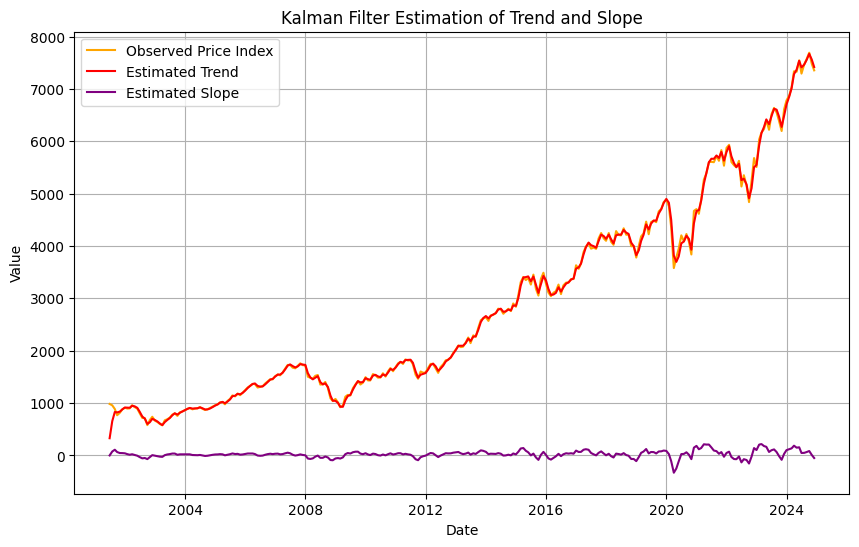

In [430]:
plt.figure(figsize=(10, 6))
plt.plot(data.select('date').to_pandas(), price_ptf, label="Observed Price Index", color='orange')
plt.plot(data.select('date').to_pandas(), trend, label="Estimated Trend", color='red')
plt.plot(data.select('date').to_pandas(), slope, label="Estimated Slope", color='purple')
plt.legend()
plt.title("Kalman Filter Estimation of Trend and Slope")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.show()

Now we use the slope to try to retrieve the track record of our investment strategy.

The strategy is :
$$
    R_{S, t} = R_{C, t} \text{ if } S_{1, t-1} > 0 \\
    R_{S, t} = \frac{3\%}{12} \text{ if } S_{1, t-1} \leq 0
$$

If the slope is positive, we long the core portfolio, otherwise we invest in cash! (assuming 3% risk free rate)

We can start by visualizing the distribution of the slope

Median value : 25.268021805673055


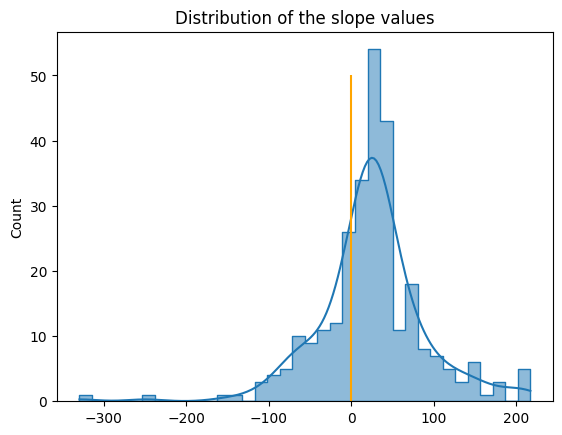

In [477]:
sns.histplot(slope, element='step', kde=True)
plt.title('Distribution of the slope values')
plt.vlines(0, 0,50, colors='orange')
print(f"Median value : {np.percentile(slope, 50)}")

We can see that most of the values for the slope are postive

In [460]:
strat = (
    data
    .sort('date')
    .with_columns(pl.Series(name="slope", values=slope))
    .with_columns(
        strat = pl.when(pl.col('slope').gt(0)).then(pl.col("replicating_ptf")).otherwise(0.03/12)
    )
    .with_columns(
        strat_price = (pl.col('strat').add(1)).cum_prod()*1000
    )
)

Then we visualize the returns of this strategy , and then the performance with an original index of 1000.

We compare it to that of the index and the replicating portfolio

Text(0.5, 1.0, 'Return of the strategy')

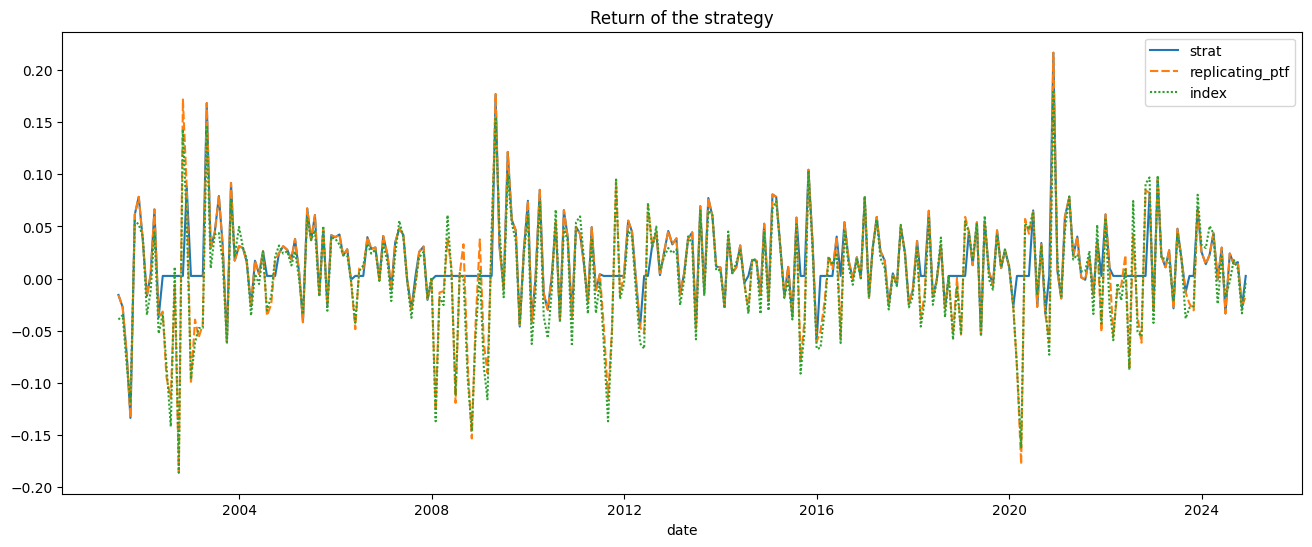

In [461]:
plt.figure(figsize=(16,6))
sns.lineplot(strat.select('date', 'strat', 'replicating_ptf', 'index').to_pandas().set_index('date'))
plt.title('Return of the strategy')

Text(0.5, 1.0, 'Return of the strategy')

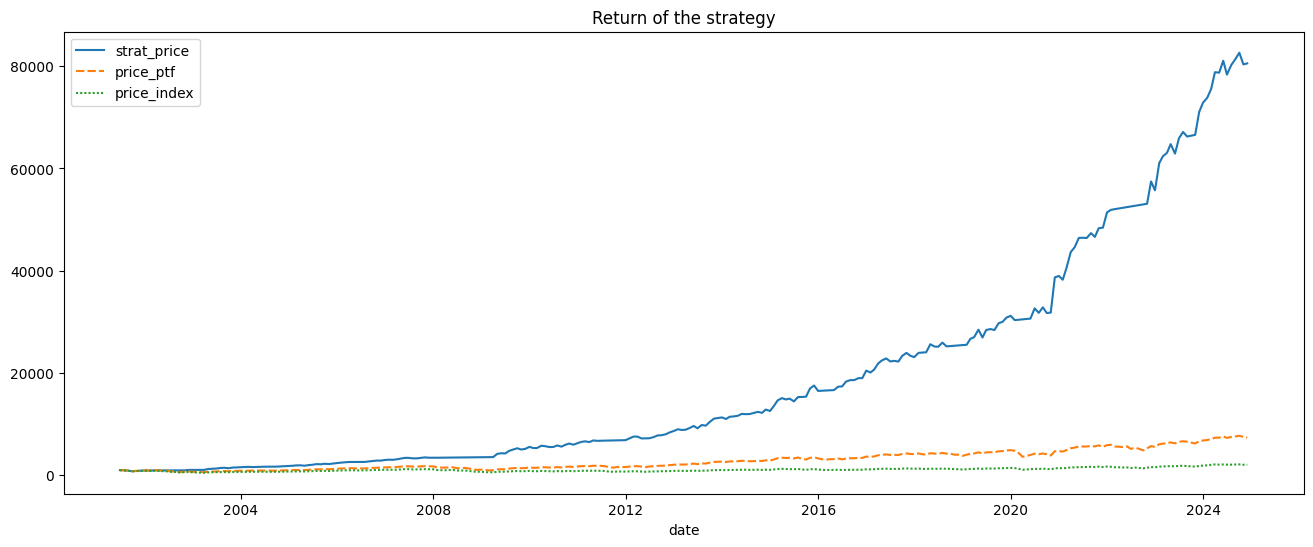

In [462]:
plt.figure(figsize=(16,6))
sns.lineplot(strat.select('date', 'strat_price', 'price_ptf', 'price_index').to_pandas().set_index('date'))
plt.title('Return of the strategy')

This strategy looks to be overperforming unrealistically, this might be because of the compounding effect (?), or because of an error in the code...

sharpe ratio:

In [459]:
sharpe = (strat.select('strat').mean() - 0.03) / strat.select('strat').std()
print(sharpe)

shape: (1, 1)
┌───────────┐
│ strat     │
│ ---       │
│ f64       │
╞═══════════╡
│ -0.368496 │
└───────────┘


Next, we want to test if this sharpe is due to luck or to skill.

We write this as :
$$
    H_0: \mathbb{E}[SR] = 0 \\
    H_1: \mathbb{E}[SR] \neq 0
$$

And the test statistic is:

$$ 
\sqrt{N} \cdot SR \cdot \delta \sim Student(N-1) 
$$

In [466]:
# we change the format of the returns so that it fits 
strat_returns = np.array(strat.select("strat").to_series().to_list())

# we compute the autocorrelation:
autocorrelation = float(np.corrcoef(strat_returns[:-1], strat_returns[1:])[0, 1])
print(f"The autocorrelation is {autocorrelation}")

The autocorrelation is -0.08701785380532219


We can then apply the test

In [478]:
N = len(strat_returns)
delta = np.sqrt(1 + 2 * autocorrelation / (1 - autocorrelation) * (1 - (1 - autocorrelation ** 12) / (12 * (1 - autocorrelation))))
test_stat = np.sqrt(N) * sharpe.to_series().to_list()[0] * delta
proba_skill = 1 -( 2 - 2 * t.cdf(test_stat, df=N-1))

We therefore have

In [479]:
print(f"This sharpe is due to skill with a probability of  {proba_skill*100:.3f}%")
print(f"This sharpe is due to luck with a probability of  {(1 - proba_skill)*100:.3f}%")

This sharpe is due to skill with a probability of  -100.000%
This sharpe is due to luck with a probability of  200.000%
